# A Brief Introduction to Clustering and Community Detection
#### Author: [Erika Fille Legara](http://www.erikalegara.net)

---
The MIT License (MIT)

Copyright (c) 2016 Erika Fille Legara

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

---

## Description
Real-world networks reveal clustering behaviour, which is exhibited in the formation of communities/clusters/partitions (used inerchangeably in this notebook) in the graph structure. When studying networks, their structure and function, it is therefore crucial to identify these bunchings. The concept of clustering and community detection oftentimes go hand-in-hand, and with other concepts such as **cliques** and **connected components**, to name a few, as well. In this recipe, we explore these different structures with a strong strong focus on clustering and community detection by looking at two general methods, and three submethods:

1. Divisive Method
    - Girvan-Newman method (**Section 3**)
2. Agglomerative Method
    - Hierarchical clustering (**Section 4**)
    - Louvain method (**Section 5**)

Note: This notebook is a supplementary material to Michael Lees and Debraj Roy's [**A Short Practical Introduction to NetworkX**](https://bitbucket.org/mhlees/networkx_ipython_notebooks) for the [2016 NTU Winter School on Complex Systems](http://www.complexity.ntu.edu.sg/Programmes/SchoolsCourses/Pages/2016-Winter-School.aspx) and also to the presentation on "Community Structures" by Erika Fille Legara at the school.

## Let's Dig-in

Import all necessary packages for this notebook to run smoothly. If you are encountering errors in importing some of the packages, please check the [0. Introduction and Setup](https://bitbucket.org/mhlees/networkx_ipython_notebooks/src/ebd2ac167e9bc896e7fc58b3cce5a05742f4e3f4/0.%20Introduction%20and%20Setup.ipynb?at=master&fileviewer=file-view-default) notebook by Michael and Debraj. 

In [1]:
try:
    ## For Network Analysis and Visualization
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    from collections import defaultdict
    import operator

    ## For Hierarchical Clustering
    from scipy.cluster import hierarchy
    from scipy.spatial import distance
    
    ## For Community Detection (Louvain Method)
    import community
    
except:
    import traceback
    traceback.print_exc()
    raise ImportError('Something failed, see above.')

## 1. Load the Network
Here, we use the Zachary's karate club network $K$ to illustrate some concepts on network structures. This network was first presented in [1].

[1] W. W. Zachary, An information flow model for conflict and fission in small groups, Journal of Anthropological Research 33, 452-473 (1977).

In [2]:
K = nx.karate_club_graph()

## 2. Network Structure and Properties

1. Clique
2. Connected Components
3. Edge Betweenness 

In [3]:
print "Number of nodes: ", K.size()
print "Number of edges: ", K.order()

Number of nodes:  78
Number of edges:  34


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


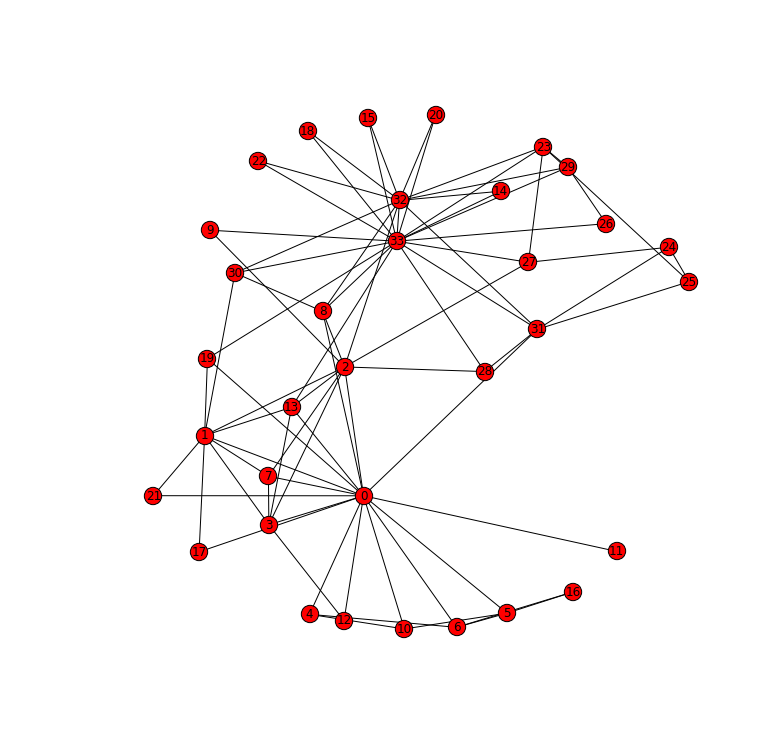

In [4]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(K)
nx.draw(K, pos)
nx.draw_networkx_labels(K, pos)
plt.show()

### Cliques
Cliques are **complete subgraphs**; that is, subgraphs where the nodes are all _directly_ connected to each other. For example, using the Karate Club network $K$, the cliques are listed below. Note that any two connected nodes in an undirected network are considered to form a **clique**.

In [5]:
print list(nx.find_cliques(K))

[[0, 1, 17], [0, 1, 2, 3, 13], [0, 1, 2, 3, 7], [0, 1, 19], [0, 1, 21], [0, 4, 10], [0, 4, 6], [0, 5, 10], [0, 5, 6], [0, 8, 2], [0, 11], [0, 12, 3], [0, 31], [1, 30], [2, 32, 8], [2, 9], [2, 27], [2, 28], [5, 16, 6], [24, 25, 31], [24, 27], [25, 23], [33, 32, 8, 30], [33, 32, 14], [33, 32, 15], [33, 32, 18], [33, 32, 20], [33, 32, 22], [33, 32, 23, 29], [33, 32, 31], [33, 9], [33, 13], [33, 19], [33, 26, 29], [33, 27, 23], [33, 28, 31]]


## 3. Divisive Method: The Girvan-Newman Algorithm
### Edge Betweenness
The **betweenness** of an edge $e$ is the fraction of shortest-paths that course through it. 

$$c_B(e)=\sum _{i,j \in V}\frac{\sigma (i,j)|e}{\sigma (i,j)},$$

where $\sigma(i,j)$ is the total number of shortest paths and $\sigma (i,j)|e$ is the number of shortest paths that pass through edge $e$. In `networkx`, the function is `edge_betweenness_centrality(G)`. Below, we illustrate the function using Zachary's karate club $K$.


In [6]:
#order the dictionary by value, which is the edge betweeness of two nodes
ebet = nx.edge_betweenness_centrality(K)
sorted_ebet = sorted(ebet.items(), key=operator.itemgetter(1), reverse=True)
sorted_ebet[0:5]

[((0, 31), 0.12725999490705373),
 ((0, 6), 0.07813428401663694),
 ((0, 5), 0.07813428401663694),
 ((0, 2), 0.0777876807288572),
 ((0, 8), 0.07423959482783014)]

Iteratively remove edges with the highest edge betweenness. For purpose of illustration, we first make a copy of the karate club network $K$. We then perform $i=10$ iterations of edge removal.

In [7]:
K2 = K.copy()

def remove_top_ebet(K2):
    ebet = nx.edge_betweenness_centrality(K2)
    sorted_ebet = sorted(ebet.items(), key=operator.itemgetter(1), reverse=True)
    edge_to_remove = sorted_ebet[0]
    K2.remove_edge(*edge_to_remove[0])

    return K2

for i in range(10):
    K2=remove_top_ebet(K2)

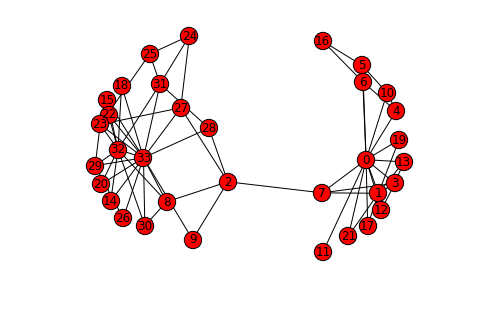

In [8]:
pos = nx.spring_layout(K2)
nx.draw(K2, pos)
nx.draw_networkx_labels(K2, pos)
plt.show()

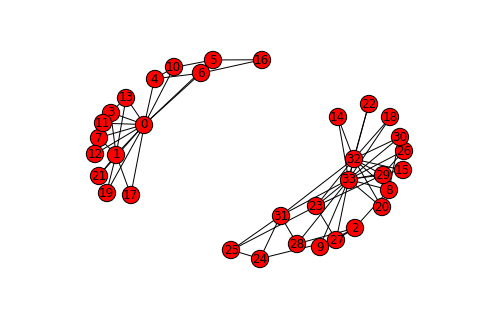

In [9]:
K2=remove_top_ebet(K2)
pos = nx.spring_layout(K2)
nx.draw(K2, pos)
nx.draw_networkx_labels(K2, pos)
plt.show()

The algorithm for finding "communities" based on edge betweenness removal was presented by Girvan-Newmann in their [2002 PNAS paper](http://www.pnas.org/content/99/12/7821). Based on the method implemented, the algorithm is classified as a _dividive procedure_ (as opposed to _agglomerative_, which is discussed in the next section. A code snippet taken [here](http://www-rohan.sdsu.edu/~gawron/python_for_ss/course_core/book_draft/Social_Networks/Networkx.html) is shown below. <img src="./figs/girvan-newman.png">

### Connected Components

**Connected components** are subgraphs where all the nodes are connected to each via a path. Unlike **cliques**, they don't have to be _directly_ connected. Moreover, the **Giant Component** refers to the network's largest component.

In [10]:
print "Number of components: ", len(list(nx.connected_components(K2))),"\n"
print list(nx.connected_components(K2))

Number of components:  2 

[[0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [32, 33, 2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]


## 4. Agglomerative Method: Hierarchical Clustering
In this method, we start with a **distance matrix** $D$, which is a matrix that provides the distance between two nodes $i$ and $j$ in network $G$. Using $D$, we then perform [hierarchical clustering](http://docs.scipy.org/doc/scipy-0.17.0/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy) in a recursive manner, group _similar_ nodes at each step. There are various ways to perform the similarity grouping using _agglomerative procedures_ such as **single**, **complete**, and **average**, to name a few. In the example below, we implement the [average/UPGMA linkage](http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.cluster.hierarchy.average.html#scipy.cluster.hierarchy.average), which is the one implemented in the Ravasz Algorithm published in [Science in 2002](http://science.sciencemag.org/content/297/5586/1551). 

In the following cells, we perform hierarchical clustering and visualize the order in which the nodes are grouped together in communities.


In [11]:
__author__ = """\n""".join(['Erika Fille Legara <legareft@ihpc.a-star.edu.sg>',
                            'Maksim Tsvetovat <maksim@tsvetovat.org',
                            'Drew Conway <drew.conway@nyu.edu>',
                            'Aric Hagberg <hagberg@lanl.gov>'])
    
'''
The original code was written by Drew Conway and Aric Hagberg and was later 
modified by Maksim Tsvetovat for his book titled “Social Network Analysis for Startups”.
EF Legara slightly modified Tsvetovat's version to address some issues 
on the ordering of keys within the path_length dictionary. Moreover,
in this code, a different agglomerative procedure is implemented.
'''

def create_hc(G, t):
    ## Set-up the distance matrix D
    labels=G.nodes()    # keep node labels
    path_length=nx.all_pairs_shortest_path_length(G)
    distances=np.zeros((len(G),len(G)))   
    for u,p in path_length.items():
        for v,d in p.items():
            distances[G.nodes().index(u)][G.nodes().index(v)] = d
            distances[G.nodes().index(v)][G.nodes().index(u)] = d
            if u==v: distances[G.nodes().index(u)][G.nodes().index(u)]=0

    # Create hierarchical cluster (HC)
    # There are various other routines for agglomerative clustering, 
    #   but here we create the HCs using the complete/max/farthest point linkage 
    Y = distance.squareform(distances) ## the upper triangular of the distance matrix 
    Z = hierarchy.average(Y)
    
    # This partition selection (t) is arbitrary, for illustrive purposes
    membership=list(hierarchy.fcluster(Z,t=t))
    
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n,p in zip(list(range(len(G))),membership):
        partition[p].append(labels[n])
        
    return Z, membership, partition

In [12]:
Z, membership, partition = create_hc(K, t=1.15) 
partition.items()

[(1, [4, 6]),
 (2, [5, 10]),
 (3, [16]),
 (4, [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]),
 (5, [28, 31]),
 (6, [23, 25]),
 (7, [24, 27]),
 (8, [26, 29]),
 (9, [8, 30]),
 (10, [14, 15, 32]),
 (11, [9, 18, 33]),
 (12, [20]),
 (13, [22])]

In [13]:
partition = {}
i = 0
for i in range(len(membership)):
    partition[i]=membership[i]

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


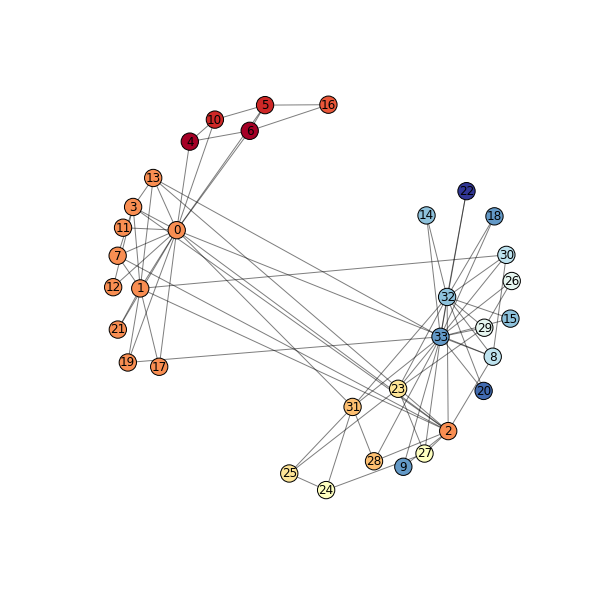

In [14]:
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx_nodes(K, pos, cmap=plt.cm.RdYlBu, node_color=partition.values())
nx.draw_networkx_edges(K, pos, alpha=0.5)
nx.draw_networkx_labels(K, pos)
plt.show()

### Dendrogram
The dendrogram allows us to visualize the order in which nodes are grouped together in the clustering process.

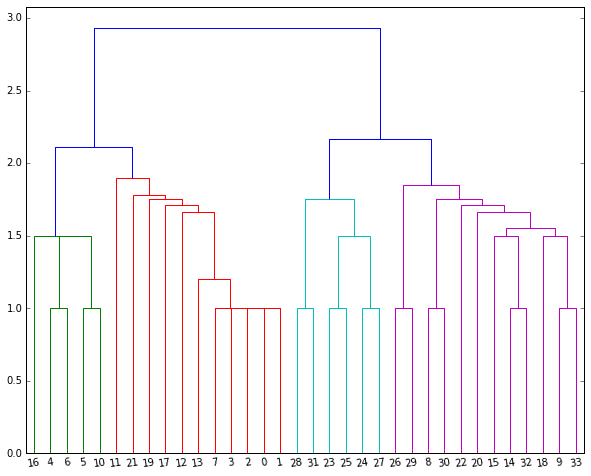

In [15]:
plt.figure(figsize=(10,8))
hierarchy.dendrogram(Z)
plt.show()

## 5. Modularity-Based Community Detection: The Louvain Method

The **community detection algorithm** that we implement in this notebook is a **modularity**-based algorithm. The **modularity** $Q$ quantifies how good a "community" or partition is, and is given by

$$Q_c =\sum _{(ij)} \left [ A_{ij}-\frac{k_ik_j}{(2m)(2m)} \right] \delta(c_i, c_j)= \sum _{u=1}^c (e_{uv}-a_u^2)$$

where $A_{ij}$ is the network's adjacency matrix, $e_{ij}$ is the fraction of edges with one of end vertices in community $u$ and another in community $v$. The higher the $Q$ of a community is, the better is the partition.

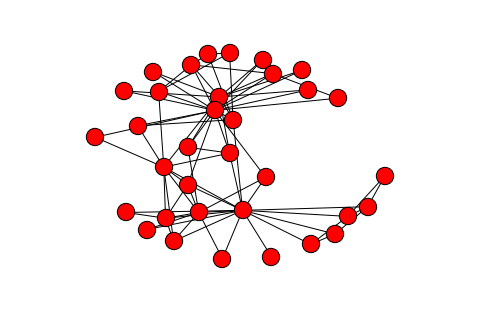

In [16]:
pos = nx.spring_layout(K)
nx.draw(K,pos)
plt.show()

Let's look for the communities using the Louvain algorithm. First, we identfiy the best partitions. 

In [17]:
partition = community.best_partition(K)

Now, let's redraw the network; this time, highlighting the different communities by node color.

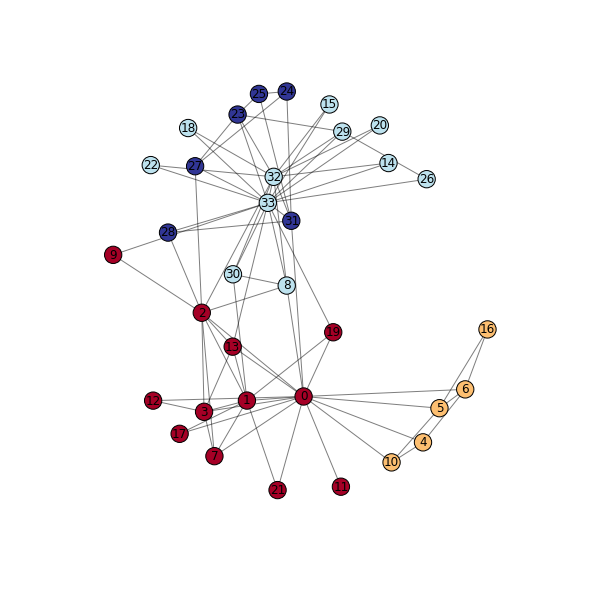

In [18]:
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx_nodes(K, pos, cmap=plt.cm.RdYlBu, node_color=partition.values())
nx.draw_networkx_edges(K, pos, alpha=0.5)
nx.draw_networkx_labels(K, pos)
plt.show()

## 6. More Real-World Networks
### Sample 1: The Marvel Universe
There are two types of Marvel Universe networks that is [available on the web](http://exposedata.com/marvel/), the Comic Network and the Hero Network. The Comic Network connects the characters to the commic issues they appeared in; on ther hand, the Hero Network represents the connections between characters as they appear in the same comic issue (weighted). In this notebook, we look at the Hero Network.

In [19]:
import unicodecsv as csv

M = nx.Graph(name="Marvel Universe")
reader = csv.reader(open("./Module 6 Datasets/hero-network.csv", 'rU'))
for row in reader:
    M.add_edge(*row)

To export this network for use in **Gephi**, use

```python
nx.write_gexf(M, "marvel_universe.gexf")
```

#### Graph Statistics

In [20]:
M.size() #number of edges

167219

In [21]:
M.order() #number of nodes

6426

In [22]:
M_cliques=list(nx.find_cliques(M))

In [23]:
print M_cliques[0:2]

[[u'ZEITGEIST II/AXEL CL', u'COACH', u'LA NUIT', u'DOOP', u'PLAZM', u'GIN GENIE/BECKAH', u'WOLVERINE/LOGAN ', u'SLUK', u'U-GO GIRL/EDIE', u'BATTERING RAM', u'ANARCHIST/TIKE ALICA'], [u'GREENSONG', u'PUDDLEGULP', u'MROTH', u'HELA [ASGARDIAN]', u'ENCHANTRESS/AMORA/HE', u'HOGUN [ASGARDIAN]', u'SIF', u'LOKI [ASGARDIAN]', u'ODIN [ASGARDIAN]', u'FRIGGA', u'HEIMDALL [ASGARDIAN]', u'FANDRAL [ASGARDIAN]', u'VOLSTAGG', u'PYLLAR', u'THOR/DR. DONALD BLAK', u'THOR II/ROGER RED NO', u'KINCAID, DR. JANE FO']]


#### Finding Communities

In [24]:
partition = community.best_partition(M)

In [25]:
len(set(partition.values()))

25

The code below may take a while to run since we are looking at a relatively large network, so we're commenting it out.'

```python
plt.figure(figsize=(10,10))
plt.axis('off')

pos = nx.spring_layout(M)
nx.draw_networkx_nodes(M, pos,cmap=plt.cm.RdYlBu, node_color=partition.values())
nx.draw_networkx_edges(M, pos, alpha=0.4)
plt.savefig("Marvel Universe.png")
```

But this is how it looks using Gephi.

<img src="./figs/marvel.png">

What are these communities? Which community is the largest? Sneak a look into the communities.

In [26]:
comm = defaultdict(list)
for k, v in partition.items():
    comm[v].append(k)

In [27]:
print comm.items()[11]

(11, [u'RYKER, MAJOR SIMON', u'NOX', u'BLACK, CYRUS', u'BURR, CLAYTON', u'MANDARIN, JAMES', u'STERN', u'LITTLETREE, LINDA', u'PENNINGTON, AUDRA', u'HASTINGS, PROF. LOUI', u'STERNBERG, DR. BERTH', u'DWORMAN, JIM', u'NANABOZHO', u'HAMIR', u'DELGADO, LUZ', u'CLOUD', u'WONG', u'SLAVINSKI, SALLY', u'RIOT/HEIDI SLATKIN', u'ASMODEUS', u'CYTTORAK', u'CAPTAIN UNIVERSE/STE', u'TROLL/', u'DRAKE, FRANKLIN', u'OVERRIDER/', u'KREA, BRUNO', u'HANSEN, BILLY', u'ROMMEL, EDWIN ROMULU', u'BLAZE, ROXANNE SIMPS', u'WEISENTHAL, DR. JONA', u'LOHAN, PETER', u'CELESTE', u'GRIFFIN', u'LANGFORD, DR. DAVID', u'FEAR EATER/KKALLAKKU', u'WOLF', u'DOC', u'INTERLOPER', u'HU, DR.', u'DEATHWATCH/STEPHAN L', u'JACOBS, BEN', u'DR. STRANGER YET', u'DEIMOS', u'BRUKNER, DR. FRANK', u'NIGHTMARE/EDVARD HAB', u'BLAZE, CRAIG', u'UMAR', u'NAVARRO', u'SIFFROR', u'SALTZ/', u'YGMLOSVORRAICH', u'FLORESCU, ANTON', u'MAINFRAME/IAN WAJLER', u'HELLSTROM, VICTORIA', u'SEWARD, ANNE', u'CHALMERS, MR.', u'KETCH, BARBARA', u'NICODEMUS', u'RYK

### Sample 2: Word Co-occurrence Network
In this example, we look at the word co-occurrence dataset used in the paper titled "News Framing of Population and Family Planning Issues via Syntactic Network Analysis" by EF Legara et al. Using a community detection algorithm, we looked for word patterns (how the words were 'arranged' or connected in the sentences of each news article) to evaluate how the media framed the population issue in the Philippines through the use of the different labels to refer to it in public discourse.

In [28]:
F = nx.read_gml("./Module 6 Datasets/word-net.gml")

In [29]:
# nx.write_gexf(F, "framing.gexf")

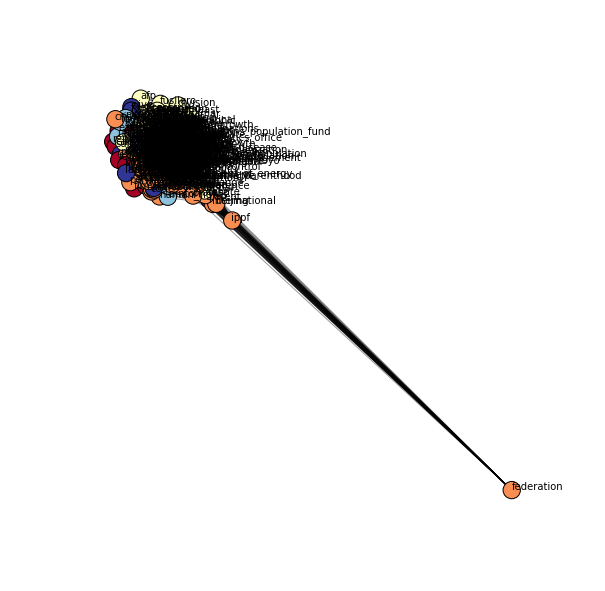

In [30]:
partition = community.best_partition(F)
plt.figure(figsize=(10,10))
plt.axis('off')

pos = nx.spring_layout(F, iterations=50)
nx.draw_networkx_nodes(F, pos,cmap=plt.cm.RdYlBu, node_color=partition.values(), label=True)
nx.draw_networkx_edges(F, pos, alpha=0.4)
#nx.draw_networkx_labels(F,pos,fontsize=14)
for n in F.nodes():
    plt.text(pos[n][0], pos[n][1], F.node[n]["label"])
plt.savefig("Frames.png")

Let's view the communities.

In [31]:
coms = defaultdict(list)
for k in partition.keys():
    coms[partition[k]].append(F.node[k]["label"])

In [32]:
#print coms[0], "\n", coms[1], "\n", coms[2], "\n", coms[3], "\n", coms[4]

### Sample 3: Political Blogs

Here, we use the dataset utilized in the paper titled "The political blogosphere and the 2004 US Election" by L. A. Adamic and N. Glance (2005). It's a directed network of hyperlinks between weblogs on US politics.

In [33]:
P = nx.read_gml("./Module 6 Datasets/polblogs.gml")

#### Some Network Properties

In [34]:
P.nodes(data=True)[0:2]

[(1,
  {'id': 1,
   'label': u'100monkeystyping.com',
   'source': u'Blogarama',
   'value': 0}),
 (2,
  {'id': 2,
   'label': u'12thharmonic.com/wordpress',
   'source': u'BlogCatalog',
   'value': 0})]

In [35]:
P.order(), P.size()

(1490, 19090)

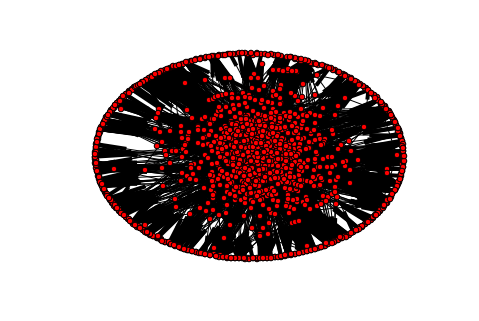

In [36]:
pos = nx.spring_layout(P)
nx.draw(P, pos, node_size=30)
plt.show()

#### Finding Communities
To perform the community detection algorithm, the **directed graph** needs to be made into an **undirected** one.

In [37]:
PR = P.to_undirected()
PR = nx.Graph(PR)

In [38]:
mypalette = ["blue","red","green", "yellow", "orange", "violet", "grey", "grey","grey"]

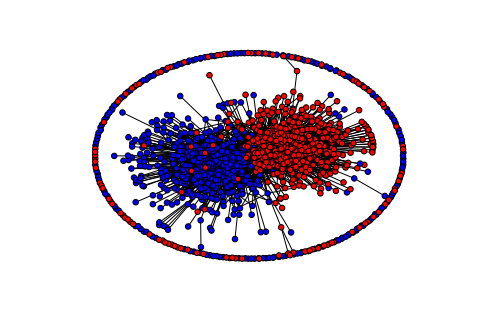

In [39]:
pos = nx.spring_layout(PR)
colors = [mypalette[PR.node[i]['value']] for i in range(1,len(PR.nodes()))]
nx.draw(PR, pos, node_color=colors, node_size=30)
plt.show()

##### Extract Giant Component

In [40]:
Gcc=sorted(nx.connected_component_subgraphs(PR), key = len, reverse=True)
GC=Gcc[0]

In [41]:
partition = community.best_partition(GC)

In [42]:
print "Number of Communities: ", len(set(partition.values()))

Number of Communities:  9


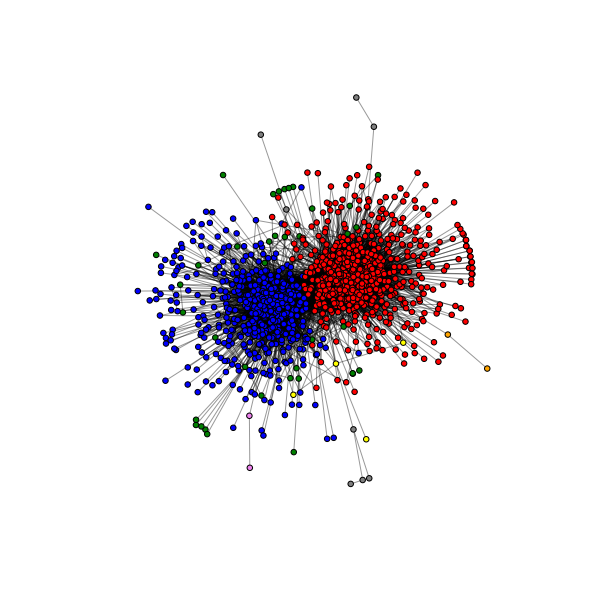

In [43]:
plt.figure(figsize=(10,10))
plt.axis('off')

colors = [mypalette[v] for v in partition.values()]

#pos = nx.spring_layout(GC, scale=3)
nx.draw_networkx_nodes(GC, pos, node_color=colors, node_size=30, label=True)
nx.draw_networkx_edges(GC, pos, alpha=0.4)
plt.savefig("polblogs.png")

### Sample 4: Your Own Network Data

#### Load the Network

#### Network Properties and Structures

## Relevant References

* **Network Science** by Albert-László Barabási (2015)
* **Social Network Analysis for Startups: Finding connections on the social web** by Maksim Tsvetovat and  Alexander Kouznetsov (2011)
* **Practical Data Science Cookbook** by Tony Ojeda et al. (2014)


## Some Network Data Repositories

* [The UCI Network Data Repository](http://deim.urv.cat/~alexandre.arenas/data/welcome.htm)
* [CCNR Network Databases](http://www3.nd.edu/~networks/resources.htm)
* [Alex Arenas Website](http://deim.urv.cat/~alexandre.arenas/data/welcome.htm)
* [Stanford Large Network Dataset Collection](http://snap.stanford.edu/data/)